## 1.Imports & Downloading

https://www.kaggle.com/competitions/playground-series-s3e24/overview

https://www.kaggle.com/code/robertoganyan/stacking

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv

import catboost as cb
from xgboost import plot_importance
from copy import deepcopy
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from sklearn.ensemble import (RandomForestClassifier, HistGradientBoostingClassifier,
                              GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
from sklearn.gaussian_process.kernels import RBF
import warnings
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer


from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
!pip install --upgrade tqdm

In [3]:
os.listdir('/kaggle/input')

['stacking-data',
 'playground-series-s3e24',
 'smoker-status-prediction-using-biosignals']

`train_df, test_df` - synthetic data, `original_df` - real-world data

In [4]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')
sample_df = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')
original_df = pd.read_csv('/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv')

In [5]:
train_df.head(3)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1


In [6]:
train_df =  train_df.drop(['id'], axis=1)
test_df = test_df.drop(['id'], axis=1)

In [7]:
assert set(original_df.columns) == set(train_df.columns)

Making the column order of synthetic and real data the same

In [8]:
original_df = original_df[train_df.columns]

In [9]:
train_df['generated'] = True
original_df['generated'] = False
test_df['generated'] = True

train_df['generated'] = train_df['generated'].astype(object)
original_df['generated'] = original_df['generated'].astype(object)
test_df['generated'] = test_df['generated'].astype(object)

In [10]:
new_train_df = pd.concat([train_df, original_df]).sample(frac=1)
new_train_df.head(5)

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,generated
96340,50,165,60,73.0,1.0,1.0,1,1,120,70,...,88,15.5,1,1.0,39,30,71,1,1,True
49880,60,165,75,96.0,1.0,0.8,1,1,138,86,...,127,14.1,1,1.0,24,24,26,0,0,True
25158,60,160,55,74.0,0.9,0.8,1,1,119,65,...,130,13.0,1,0.7,28,24,21,0,0,True
14639,40,155,50,75.0,0.9,0.9,1,1,118,81,...,134,13.0,1,0.6,18,10,14,0,0,True
121357,45,180,85,94.0,1.0,0.8,1,1,119,73,...,145,15.7,1,0.9,30,48,32,0,1,True


In [11]:
assert len(new_train_df) == len(train_df) + len(original_df)
len(new_train_df)

198240

In [12]:
new_train_df.drop_duplicates(inplace=True)
len(new_train_df)

192723

## 2. Preprocessing

There is a function describe in pandas, which counts statistics for numeric features

In [13]:
new_train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,192723.0,44.280112,11.882563,20.0,40.0,40.0,55.0,85.0
height(cm),192723.0,165.165782,8.888281,130.0,160.0,165.0,170.0,190.0
weight(kg),192723.0,66.932961,12.645668,30.0,55.0,65.0,75.0,135.0
waist(cm),192723.0,82.842144,9.026868,51.0,77.0,83.0,89.0,129.0
eyesight(left),192723.0,1.007196,0.419985,0.1,0.8,1.0,1.2,9.9
eyesight(right),192723.0,1.002476,0.412585,0.1,0.8,1.0,1.2,9.9
hearing(left),192723.0,1.024216,0.153720,1.0,1.0,1.0,1.0,2.0
hearing(right),192723.0,1.023879,0.152672,1.0,1.0,1.0,1.0,2.0
systolic,192723.0,122.329141,12.903359,71.0,113.0,121.0,130.0,233.0
relaxation,192723.0,76.725342,9.121638,40.0,70.0,78.0,82.0,146.0


We'll add more statistics

In [14]:
def construct_features_df(df):
    features_df = pd.DataFrame(index=df.columns)
    features_df['nunique'] = df.nunique() #cnt of unique elements
    features_df['count'] = df.count() #cnt of non nans
    features_df['nan'] = df.isna().sum()
    features_df['precent_nan'] = features_df['nan'] / (features_df['nan'] + features_df['count'])
    features_df['dtype'] = df.dtypes
    
    features_df = pd.concat([features_df, df.describe().T], axis=1, join='outer')
    return features_df

features_train = construct_features_df(new_train_df.drop(['generated'], axis=1))
features_test = construct_features_df(test_df.drop(['generated'], axis=1))

In [15]:
features_train

,nunique,count,nan,precent_nan,dtype,count,mean,std,min,25%,50%,75%,max
age,18,192723,0,0.0,int64,192723.0,44.280112,11.882563,20.0,40.0,40.0,55.0,85.0
height(cm),15,192723,0,0.0,int64,192723.0,165.165782,8.888281,130.0,160.0,165.0,170.0,190.0
weight(kg),29,192723,0,0.0,int64,192723.0,66.932961,12.645668,30.0,55.0,65.0,75.0,135.0
waist(cm),548,192723,0,0.0,float64,192723.0,82.842144,9.026868,51.0,77.0,83.0,89.0,129.0
eyesight(left),20,192723,0,0.0,float64,192723.0,1.007196,0.419985,0.1,0.8,1.0,1.2,9.9
eyesight(right),18,192723,0,0.0,float64,192723.0,1.002476,0.412585,0.1,0.8,1.0,1.2,9.9
hearing(left),2,192723,0,0.0,int64,192723.0,1.024216,0.153720,1.0,1.0,1.0,1.0,2.0
hearing(right),2,192723,0,0.0,int64,192723.0,1.023879,0.152672,1.0,1.0,1.0,1.0,2.0
systolic,128,192723,0,0.0,int64,192723.0,122.329141,12.903359,71.0,113.0,121.0,130.0,233.0
relaxation,94,192723,0,0.0,int64,192723.0,76.725342,9.121638,40.0,70.0,78.0,82.0,146.0


In [16]:
features_test

,nunique,count,nan,precent_nan,dtype,count,mean,std,min,25%,50%,75%,max
age,18,106171,0,0.0,int64,106171.0,44.426538,11.897138,20.0,40.0,40.0,55.0,85.0
height(cm),16,106171,0,0.0,int64,106171.0,165.221322,8.837065,135.0,160.0,165.0,170.0,190.0
weight(kg),26,106171,0,0.0,int64,106171.0,67.125618,12.586569,30.0,60.0,65.0,75.0,130.0
waist(cm),508,106171,0,0.0,float64,106171.0,82.999892,8.946584,51.0,77.0,83.0,89.0,127.7
eyesight(left),20,106171,0,0.0,float64,106171.0,1.004776,0.397690,0.1,0.8,1.0,1.2,9.9
eyesight(right),18,106171,0,0.0,float64,106171.0,0.999483,0.385752,0.1,0.8,1.0,1.2,9.9
hearing(left),2,106171,0,0.0,int64,106171.0,1.024216,0.153719,1.0,1.0,1.0,1.0,2.0
hearing(right),2,106171,0,0.0,int64,106171.0,1.023980,0.152988,1.0,1.0,1.0,1.0,2.0
systolic,114,106171,0,0.0,int64,106171.0,122.475403,12.765542,71.0,114.0,121.0,130.0,213.0
relaxation,78,106171,0,0.0,int64,106171.0,76.820676,9.018782,40.0,70.0,78.0,82.0,140.0


We can see, that data has no missing values. Also data has categorical features such as `dental caries`, `hearing(left)`, `hearing(right)`, `Urine protein`

In [17]:
new_train_df

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,generated
96340,50,165,60,73.0,1.0,1.0,1,1,120,70,...,88,15.5,1,1.0,39,30,71,1,1,True
49880,60,165,75,96.0,1.0,0.8,1,1,138,86,...,127,14.1,1,1.0,24,24,26,0,0,True
25158,60,160,55,74.0,0.9,0.8,1,1,119,65,...,130,13.0,1,0.7,28,24,21,0,0,True
14639,40,155,50,75.0,0.9,0.9,1,1,118,81,...,134,13.0,1,0.6,18,10,14,0,0,True
121357,45,180,85,94.0,1.0,0.8,1,1,119,73,...,145,15.7,1,0.9,30,48,32,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69986,25,175,75,83.0,1.0,1.0,1,1,123,71,...,106,16.6,1,1.2,26,20,45,0,1,True
1240,40,160,55,68.0,1.2,1.2,1,1,107,72,...,101,13.3,1,0.6,20,22,13,1,0,True
116832,55,165,75,89.1,0.9,1.2,1,1,133,98,...,75,16.3,1,1.0,20,18,51,0,1,True
3405,45,180,85,88.0,1.2,0.9,1,1,118,78,...,111,16.4,1,0.9,18,28,26,0,1,True


In [18]:
for df in [new_train_df, test_df, train_df, original_df]:
    df['dental caries'] = df['dental caries'].astype('object')
    df['hearing(left)'] = df['hearing(left)'].astype('object')
    df['hearing(right)'] = df['hearing(right)'].astype('object')
    df['Urine protein'] = df['Urine protein'].astype('object')

In [19]:
numeric_features = []
categorical_features = []
for col in new_train_df.columns:
    if col == 'smoking' or col == 'generated':
        continue
    if new_train_df[col].dtype == object:
        categorical_features.append(col)
    else:
        numeric_features.append(col)    

In [20]:
cat_features_with_different_set_of_values = []
for col in categorical_features:
    if len(set(new_train_df[col].value_counts().keys()) ^ set(test_df[col].value_counts().keys())) != 0:
        cat_features_with_different_set_of_values.append(col)

In [21]:
cat_features_with_different_set_of_values

[]

Great! We don't have any conflicts with sets of categorical values

## 3. Exploratory Data Analysis

In `seaborn` there is a useful function `pairplot`, but the results of it are not clearly visible. So we'll implement our own functions

In [22]:
# sns.pairplot(train_df, diag_kind="kde")

We can see we have no categorical features

In [23]:
new_train_df.dtypes

age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)           object
hearing(right)          object
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein           object
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental caries           object
smoking                  int64
generated               object
dtype: object

In [24]:
def custom_plot0(plot_func, train, test, orig, columns, name, *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 1, figsize = (10,50))
    fig.suptitle(f'{name}' + ' features \n \n \n', fontsize = 20)
    
    for i, col in enumerate(columns):
        plot_func(data=train[col], ax=axs[i], color = 'r', *args, **kwargs)
        plot_func(data=test[col], ax=axs[i], color = 'g', *args, **kwargs)
        plot_func(data=orig[col], ax=axs[i], color = sns.xkcd_rgb['sky blue'], *args, **kwargs)
        
        axs[i].set_title(f'{name} {col}')
    fig.legend(['Train_generated', 'Test_generated', 'Train_original'])
        
    plt.tight_layout()

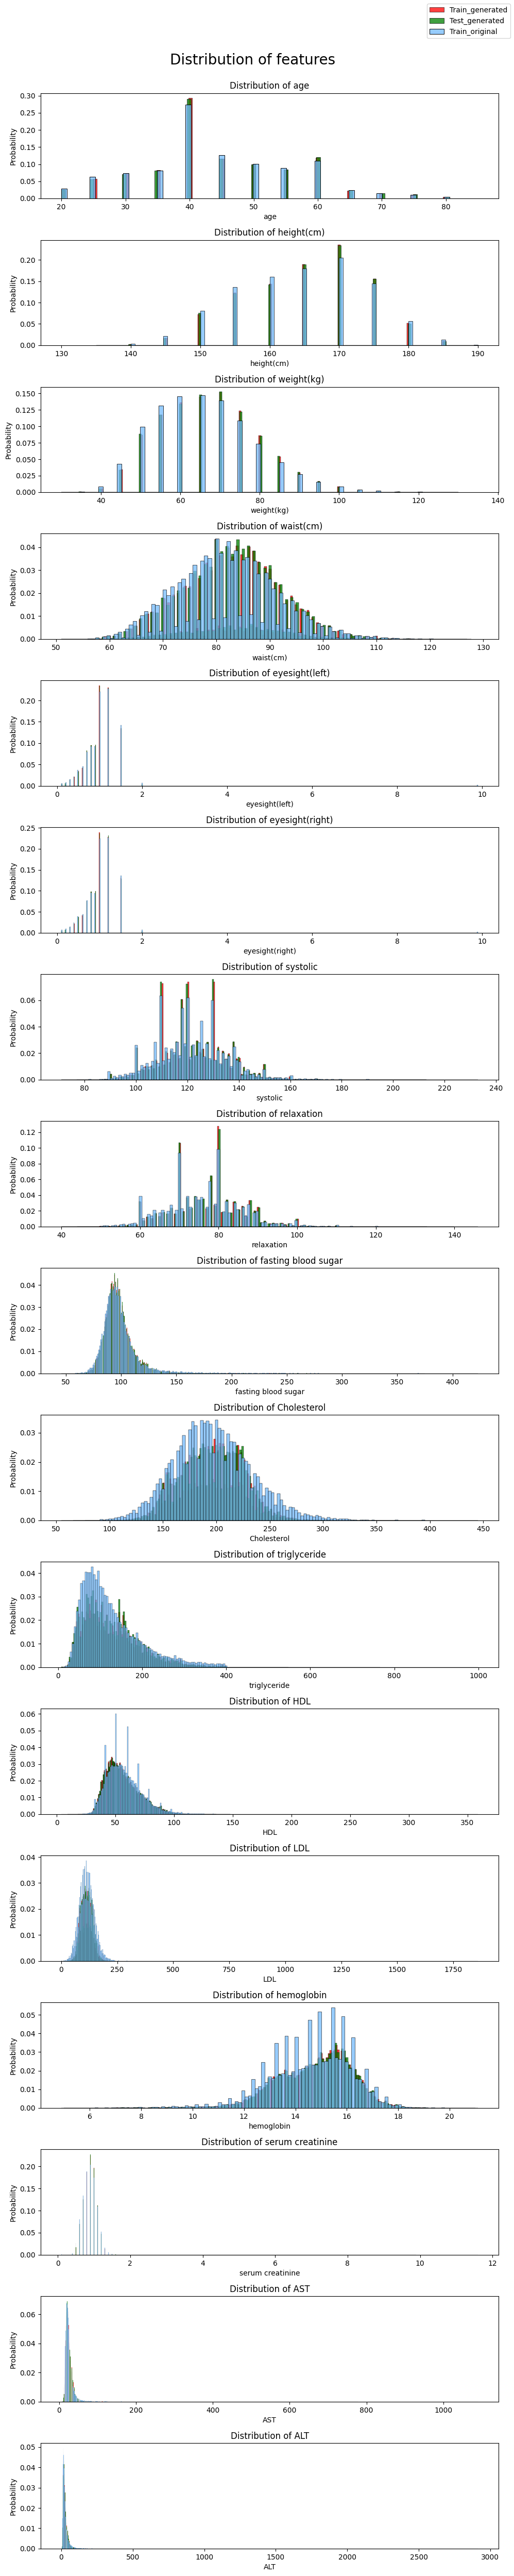

In [25]:
custom_plot0(sns.histplot, train_df, test_df, original_df, numeric_features[:-1], 'Distribution of', kde=False,
            stat='probability')

Distributions are kinda similar

In [26]:
def custom_plot1(train, orig, columns, name, names, *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 2, figsize = (10,50))
    fig.suptitle(f'{name}' + ' features \n \n', fontsize = 20)
    
    for i, col in enumerate(columns):
        sns.kdeplot(data=train, ax=axs[i][0], x = col, *args, **kwargs)
        sns.kdeplot(data=orig, ax=axs[i][1], x = col, *args, **kwargs)
              
    for ax, col in zip(axs[0], names):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], columns):
        ax.set_ylabel(row, rotation=90, size='large')
        
    for ax, row in zip(axs[:,1], columns):
        ax.set_ylabel('')
        
    plt.tight_layout()

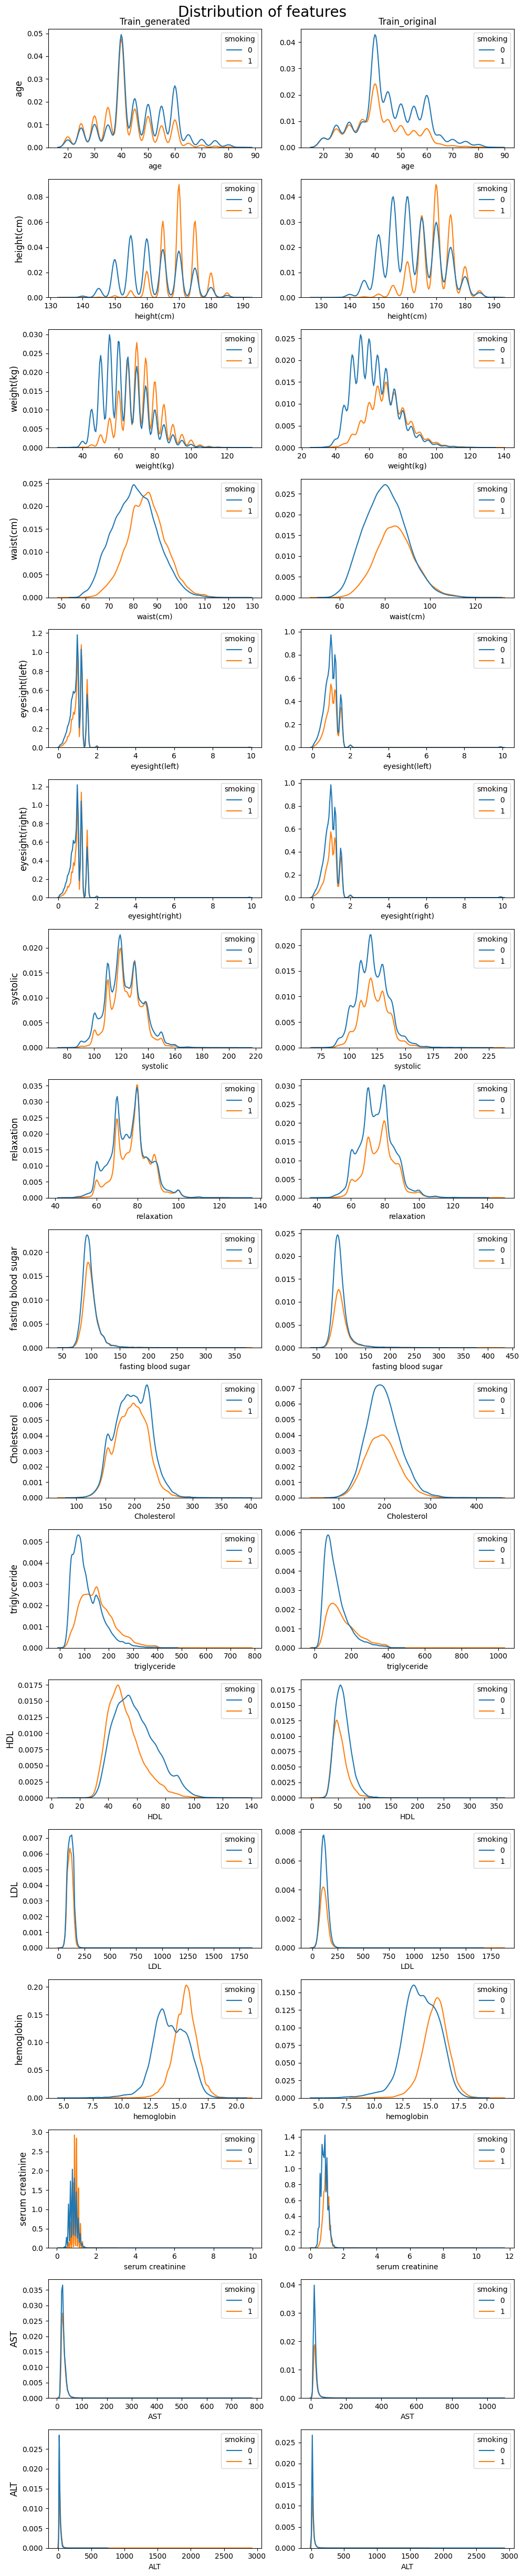

In [27]:
custom_plot1(train_df, original_df, numeric_features[:-1], 'Distribution of',names = ['Train_generated', 'Train_original'],
             warn_singular=False, hue='smoking')

Seems like generated and original data  do differ

In [28]:
def custom_plot2(plot_func, train, test, orig, columns, name, *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 3, figsize = (10,50))
    fig.suptitle(f'{name}' + ' features \n \n', fontsize = 20)
    
    for i, col in enumerate(columns):
        plot_func(data=train[col], ax=axs[i][0], color = 'r', *args, **kwargs)
        plot_func(data=test[col], ax=axs[i][1], color = 'g', *args, **kwargs)
        plot_func(data=orig[col], ax=axs[i][2], color = sns.xkcd_rgb['sky blue'], *args, **kwargs)
        
    names = ['Train_generated', 'Test_generated', 'Train_original']        
    for ax, col in zip(axs[0], names):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], columns):
        ax.set_ylabel(row, rotation=90, size='large')
        
    plt.tight_layout()

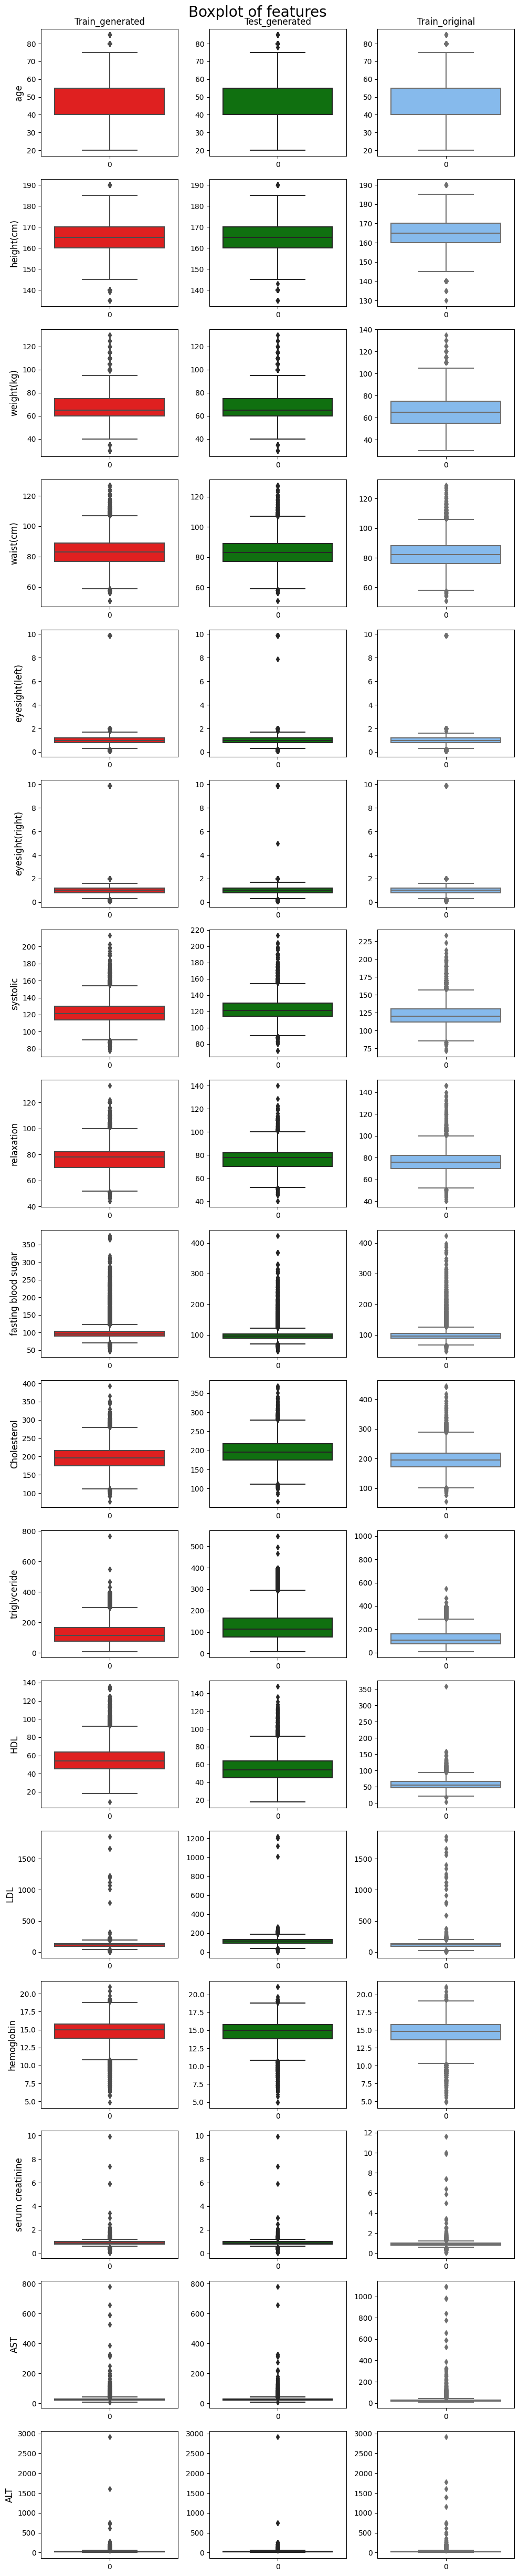

In [29]:
custom_plot2(sns.boxplot, train_df, test_df, original_df, numeric_features[:-1], 'Boxplot of')

Seems like boxplots found a lot of outliners, but I won't risk to "process" them

Let's check `scatterplot` of features and target, perhaps we'll notice some kind of dependence. We check only `train`

In [30]:
def custom_plot3(plot_func, train, columns, name, *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 1, figsize = (10,50))
    fig.suptitle(f'{name}' + ' features \n \n', fontsize = 20)
    
    for i, col in enumerate(columns):
        
        plot_func(data=train, ax=axs[i],x = col, y = 'smoking', color = 'b', *args, **kwargs)
        
        axs[i].set_title(f'{name} {col}')
        
    plt.tight_layout()

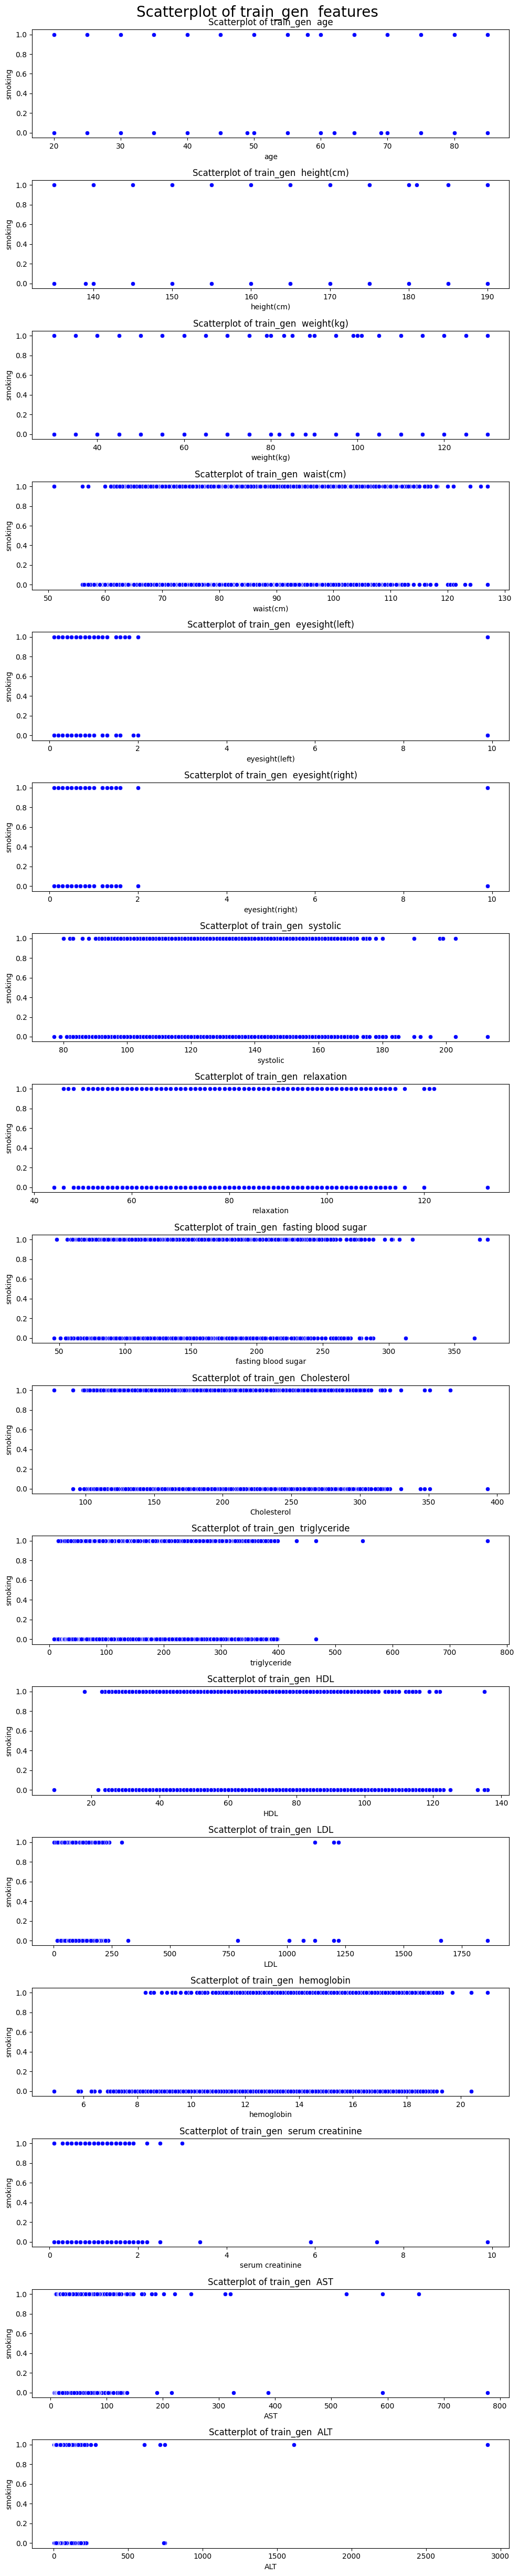

In [31]:
custom_plot3(sns.scatterplot, train_df, numeric_features[:-1], 'Scatterplot of train_gen ')

We did not get any useful information. What about linear dependence (Pearson correlation coefficient)?

<Axes: >

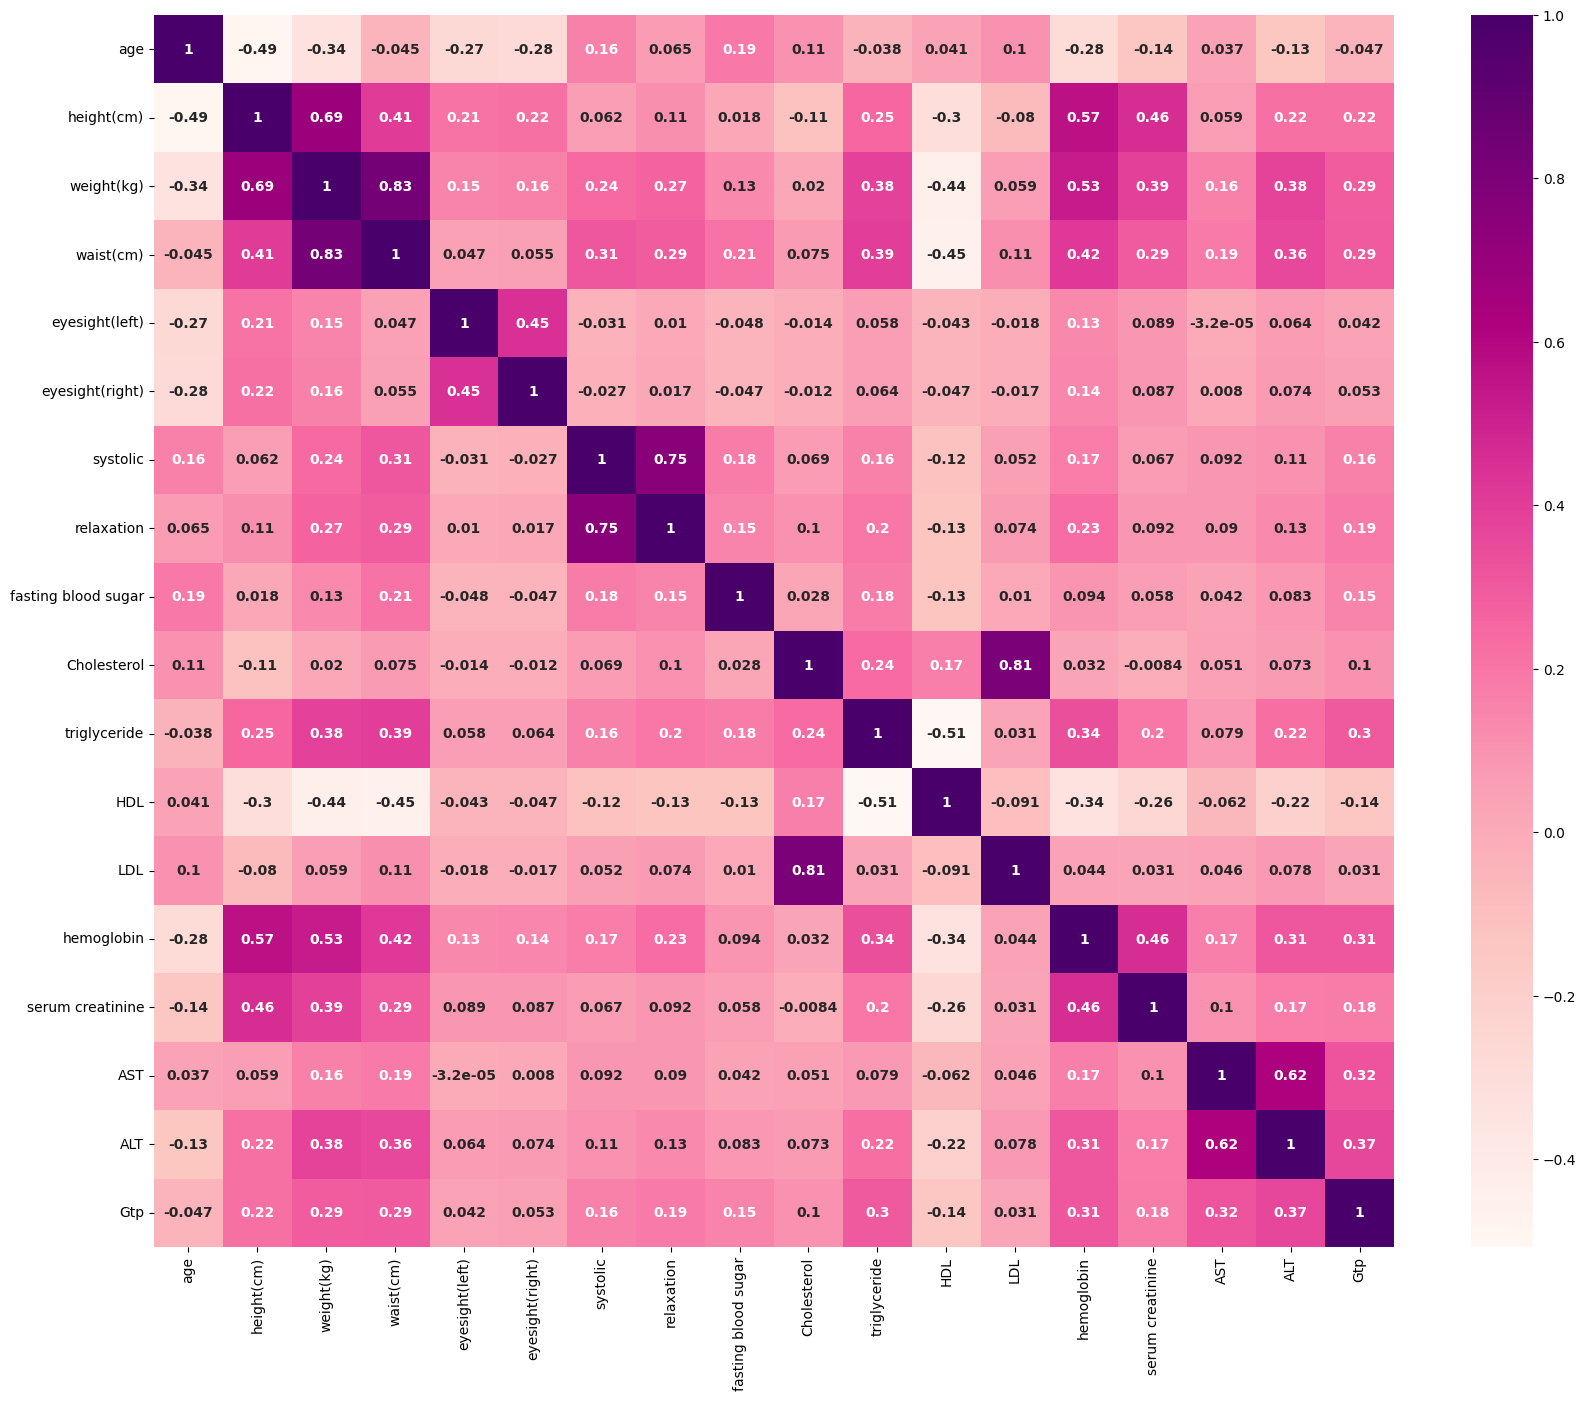

In [32]:
corr_fi = train_df[numeric_features].corr()
fig = plt.figure(figsize=(20, 16))
sns.heatmap(corr_fi,
            xticklabels = corr_fi.columns,
            yticklabels = corr_fi.columns,
            annot = True,
            cmap="RdPu",
            annot_kws={"weight":"bold"})

Don't have any linear dependence between numerical features

In [33]:
def custom_plot4(train, test, orig, columns, name, *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 3, figsize = (6,12))
    fig.suptitle(f'{name}' + ' features \n \n \n', fontsize = 20)
    
    for i, col in enumerate(columns):
        axs[i][0].pie(train[col].value_counts(), labels =  train[col].value_counts().keys(),
                      shadow=True, *args, **kwargs)
        if col != 'outcome':
            axs[i][1].pie(test[col].value_counts(),labels =  test[col].value_counts().keys(),
                          shadow=True, *args, **kwargs)
        else:
            axs[i][1].pie(train[col].value_counts(), labels =  train[col].value_counts().keys(),
                          shadow=True, *args, **kwargs)
        axs[i][2].pie(orig[col].value_counts(),labels =  orig[col].value_counts().keys(),
                      shadow=True, *args, **kwargs)
        

    names = ['Train_generated', 'Test_generated', 'Train_original']        
    for ax, col in zip(axs[0], names):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], columns):
        ax.set_ylabel(row, rotation=90, size='large')
        
    plt.tight_layout()

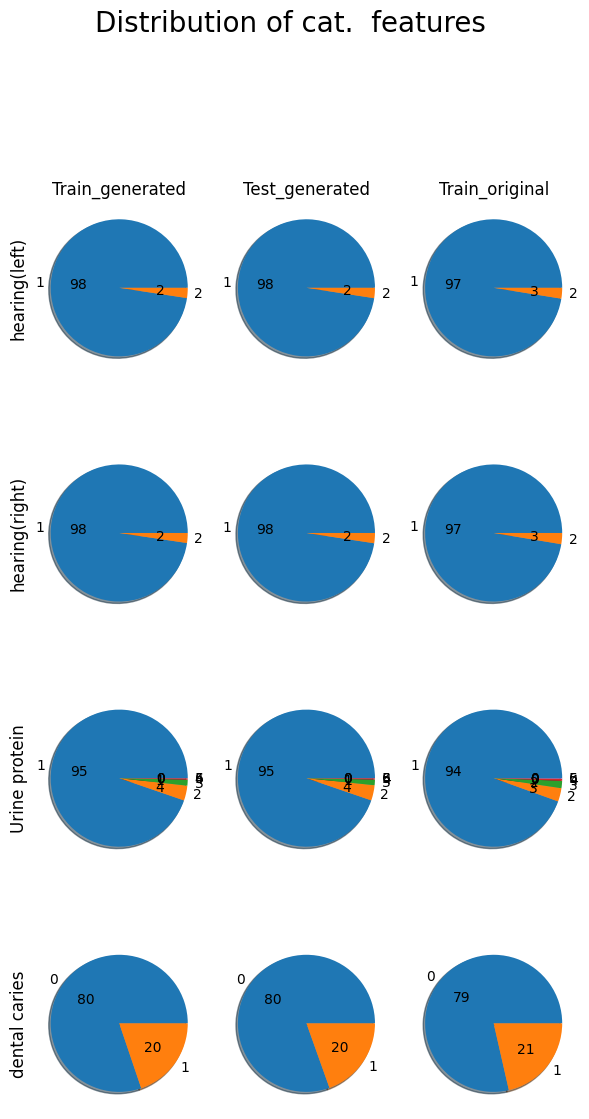

In [34]:
custom_plot4(train_df, test_df, original_df, categorical_features, 'Distribution of cat. ', autopct='%1.f')

In [35]:
def custom_plot5(plot_func, train, orig, columns, name, figsize=(10,30),names = ['Train_generated',  'Train_original'],
                 *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 2, figsize = figsize)
    fig.suptitle(f'{name}' + ' features \n \n', fontsize = 20)
    
    for i, col in enumerate(columns):
        plot_func(data=train, x=col, ax=axs[i][0], order = sorted(train[col].value_counts().index),
                  *args, **kwargs)
        plot_func(data=orig, x=col, ax=axs[i][1], order = sorted(orig[col].value_counts().index),
                  *args, **kwargs)
            
        axs[i][0].legend(fontsize=15)
        axs[i][1].legend(fontsize=15)
        
    for ax, col in zip(axs[0], names):
        ax.set_title(col, fontsize=18)

    for ax, row in zip(axs[:,0], columns):
        ax.set_ylabel(row, rotation=90, fontsize=18)
        
    plt.tight_layout()

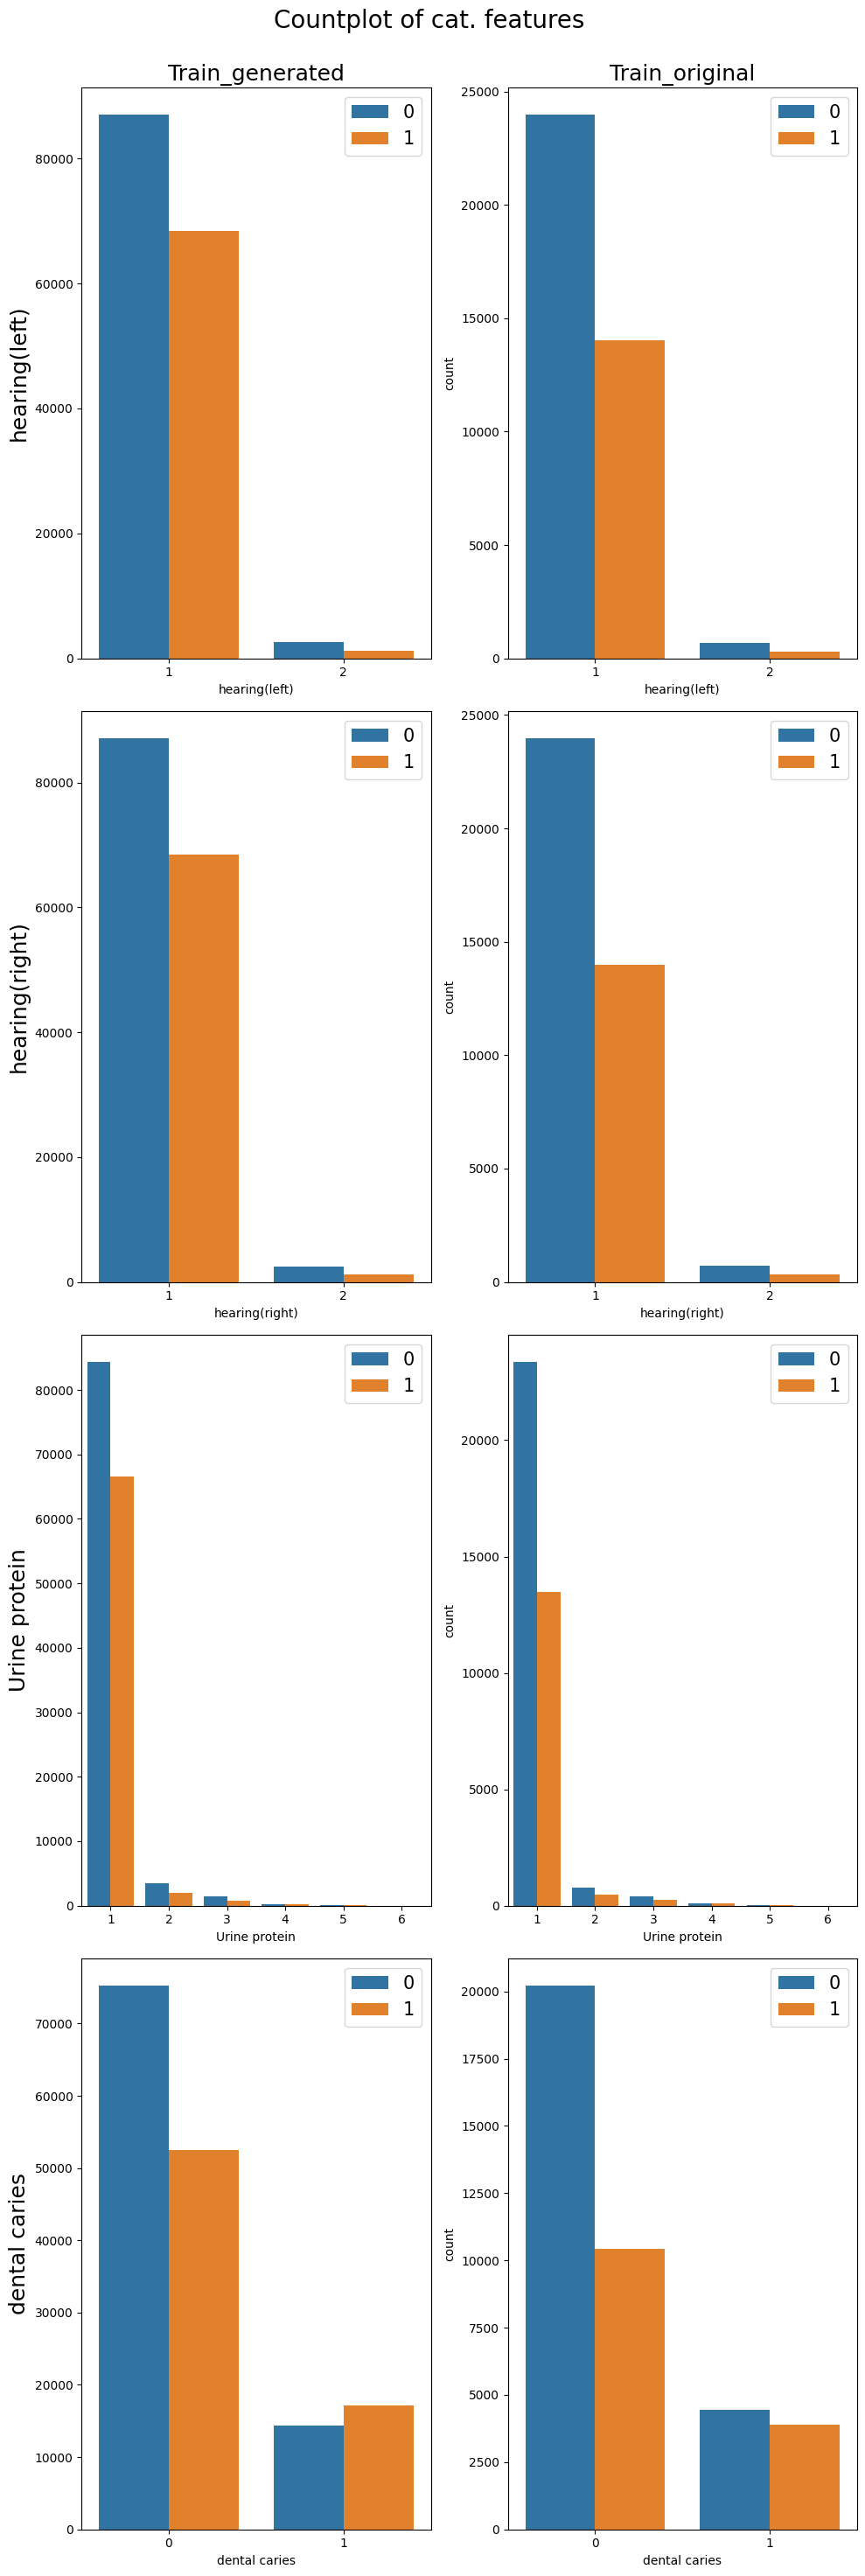

In [36]:
custom_plot5(sns.countplot, train_df, original_df, categorical_features, 'Countplot of cat.', hue='smoking')

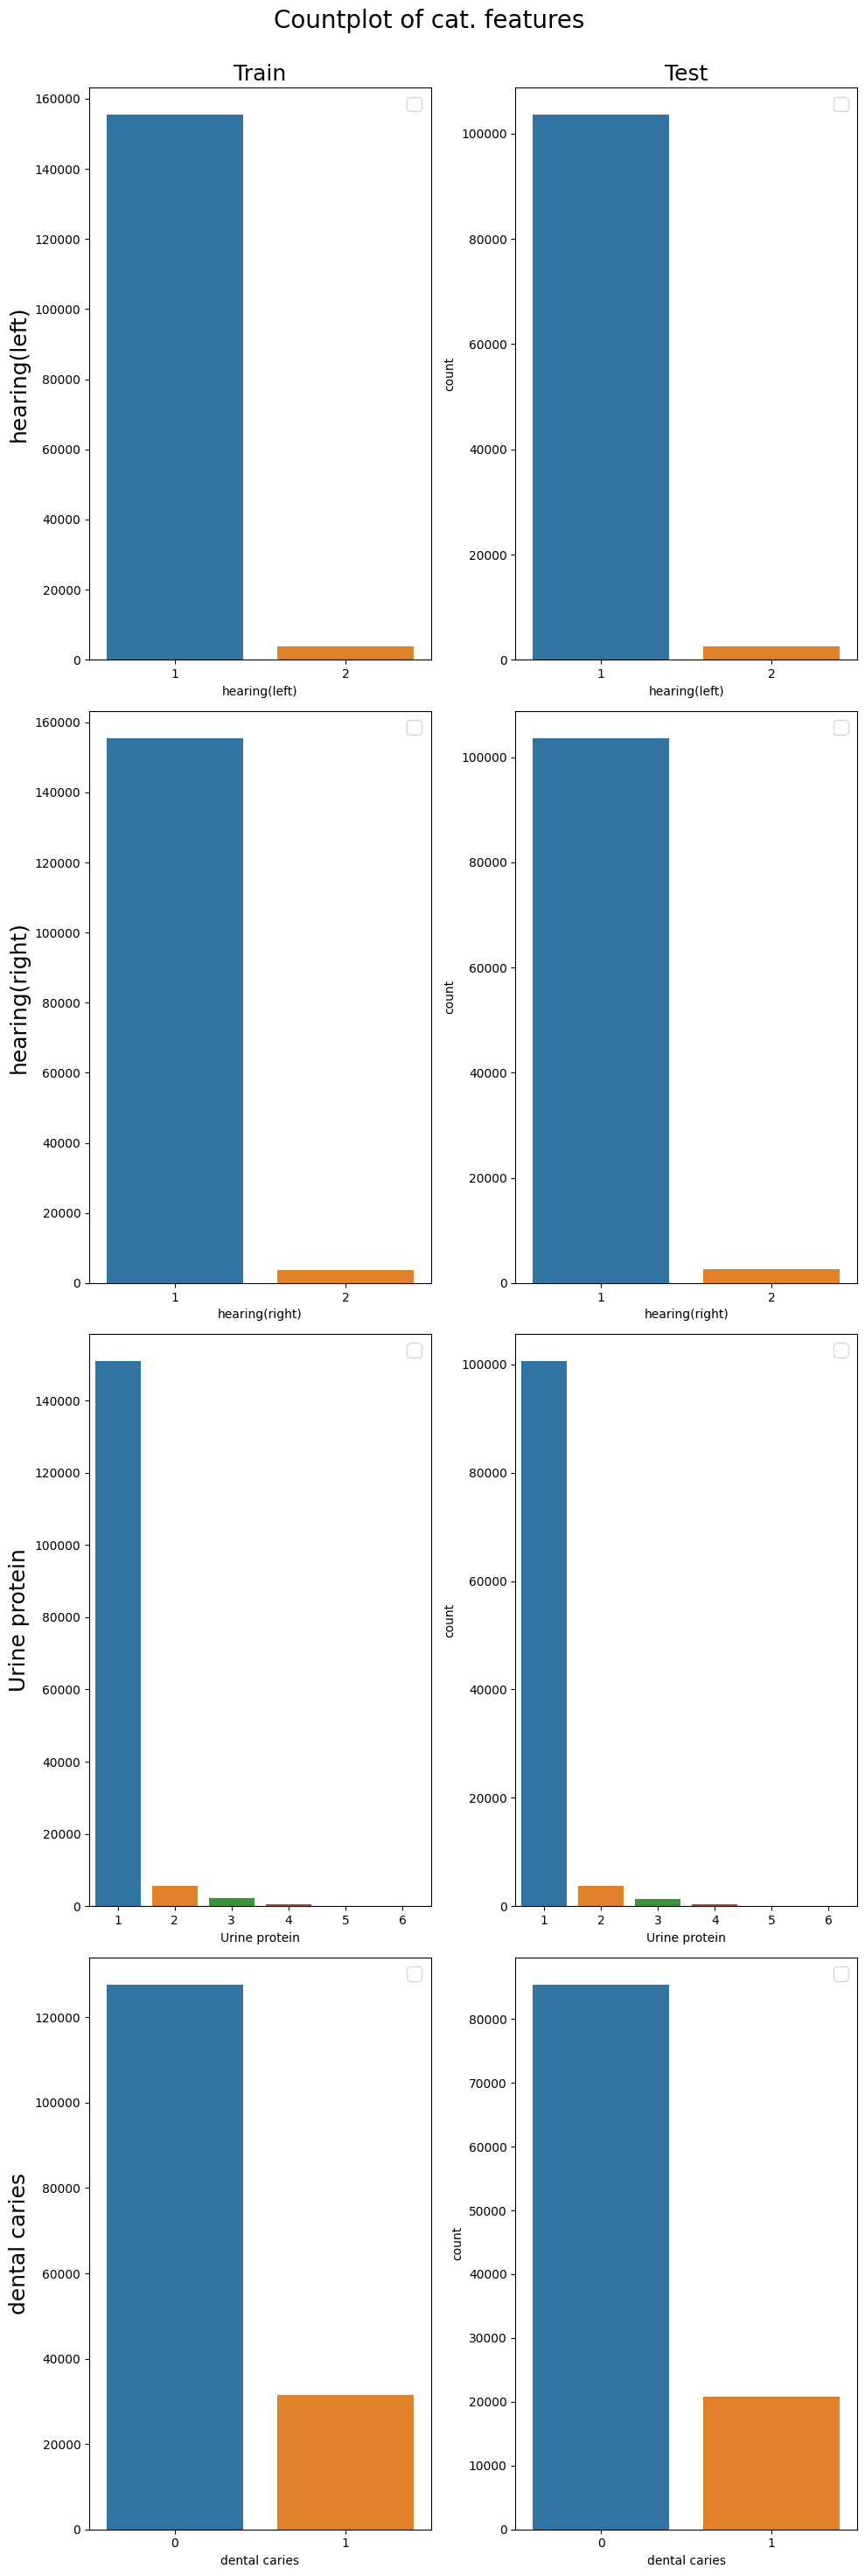

In [37]:
custom_plot5(sns.countplot, train_df, test_df, categorical_features, 'Countplot of cat.',
             names = ['Train',  'Test'])

Ratio of target's bars in countplot are kinda similar in different datasets

## 4. Adversarial validation

Good notebook https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation

Previously we established that train and test has the same distribution based on graphs. But we can establish this in more proper way: adversarial validation.

Basically, we train our model to classify if object is from train ds or test. If area under ROC-curve is ~ 0.5 then distributions are same

We'll use XGB boost for adversarial validation

In [38]:
adv_train = train_df.copy()
adv_train_orig = original_df.copy()
adv_train_all = new_train_df.copy()
adv_test = test_df.copy()

for df in [adv_train, adv_train_orig, adv_train_all, adv_test]:
    df.drop(['smoking', 'generated'], axis=1, errors='ignore', inplace=True)

In [39]:
def adversarial_validation(df1, df2, cat_feat, y):
    df3 = pd.concat([df1,df2])
    for col in cat_feat:
        df3[col] = df3[col].astype('category')
        
    df3 = df3.sample(frac=1)
    
#     XGBdata = xgb.DMatrix(data=df3.drop([y], axis=1), label=df3[y], enable_categorical=True)
    
    # our XGBoost parameters
    params = {"objective":"binary:logistic",
              "eval_metric":"logloss",
              'learning_rate': 0.05,
             'enable_categorical': True,
              'tree_method':"hist"}
    
    param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
#     "colsample_bytree": [ 0.3, 0.5 , 0.8 ], 
#     "reg_alpha": [0, 0.5, 1, 5], #l1 reg
#     "reg_lambda": [0, 0.5, 1, 5],#l2 reg
        
#     'n_estimators': [50, 100],
#     "max_depth" : [10, 20, 40]        
        'n_estimators': [50],
    "max_depth" : [10, 20]        
    }
    
    
    grid_search = GridSearchCV(XGBClassifier(**params), 
                           param_grid=param_grid, 
                           scoring='roc_auc',
                           n_jobs=-1, 
                               cv=5,  # stratified kfold as default
                              )
    grid_result = grid_search.fit(X=df3.drop([y], axis=1), y=df3[y])
    return grid_result
                               
   

        # Other method for cross validation, implemented in xgb
#     cross_val_results = cv(dtrain=XGBdata, params=params, 
#                            nfold=5, metrics="auc", 
#                            num_boost_round=200,early_stopping_rounds=20,
#                            as_pandas=True)
    
    
#     return cross_val_results.sort_values(by='test-auc-mean', ascending=False).head(1)['test-auc-mean']
    
    

In [40]:
adv_train_all['is_train'] = 1
adv_test['is_train'] = 0
res = adversarial_validation(adv_train_all, adv_test, categorical_features, 'is_train')
score_cv = pd.DataFrame(res.cv_results_).sort_values(by='rank_test_score').iloc[0]['mean_test_score']
print(f'Cross-val auc = {score_cv}')

Cross-val auc = 0.5295152735062383


In [41]:
adv_test.shape[1], adv_train_all.shape[1]

(23, 23)

Text(0, 0.5, 'True Positive Rate')

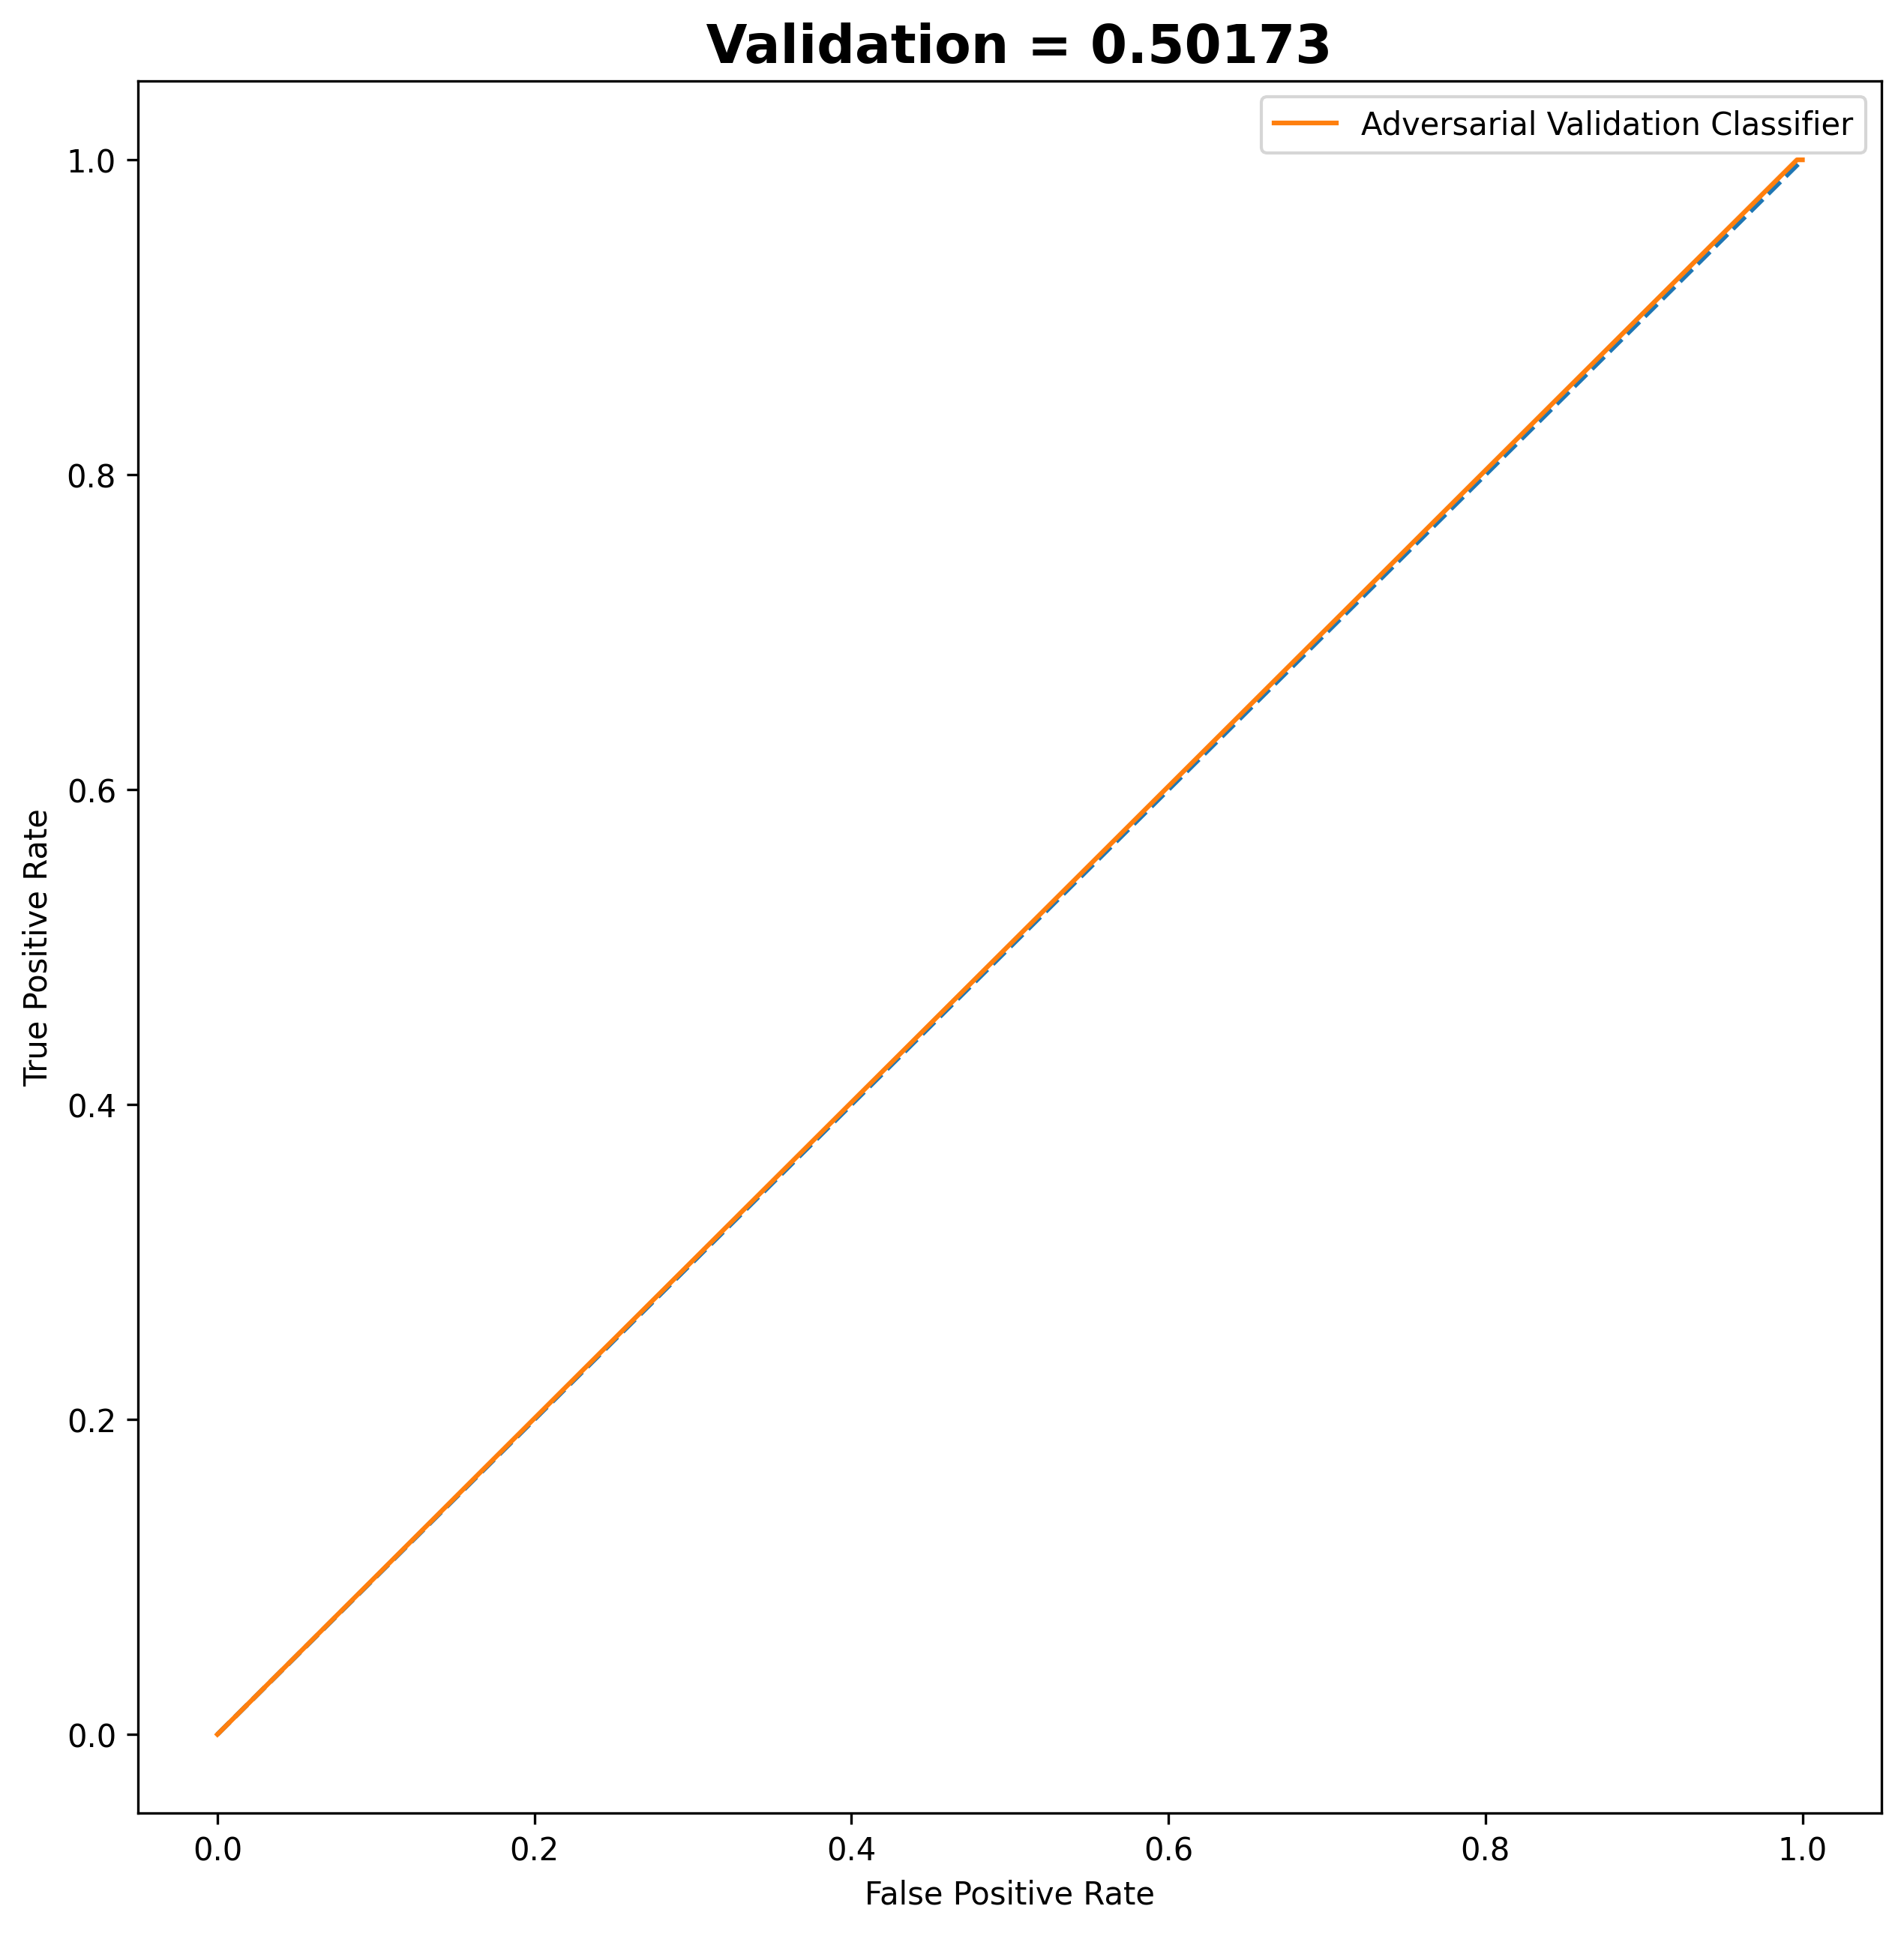

In [42]:
all_df = pd.concat([adv_train_all, adv_test])
for col in categorical_features:
    all_df[col] = all_df[col].astype('category')
predictions = res.best_estimator_.predict(all_df.drop(['is_train'], axis=1))
score = roc_auc_score(all_df['is_train'], predictions)
fpr, tpr, _ = roc_curve(all_df['is_train'], predictions)    

plt.figure(figsize = (10, 10), dpi = 300)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--")
sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
plt.title(f' Validation = {np.mean(score):.5f}', weight = 'bold', size = 17)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Our data is alright

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

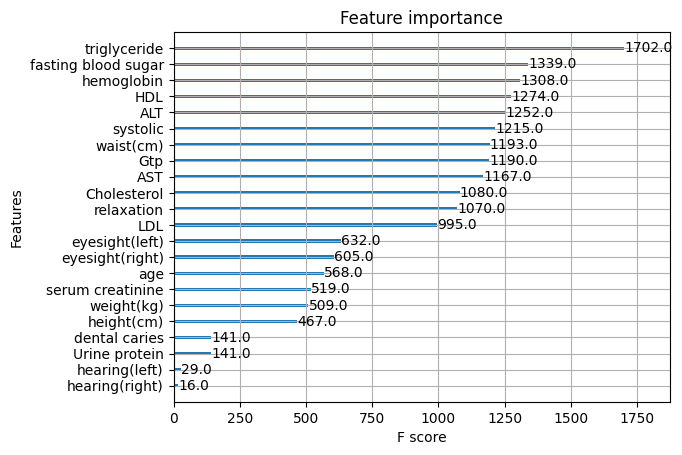

In [43]:
plot_importance(res.best_estimator_)

## 5. Ensemble of models aka `Stacking`

Good guide tho
https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python#Ensembling-&-Stacking-models

Briefly, what we need for stacking:

0. Perhaps we have train and test data
1. Use kfold cv for train.
2. For each model we fit model on (n-1) folds and predict on 1 fold. Predicted values have same shape as train.shape[0] tho. If we concat predicted values of all models in ensemble, these values are new features for meta-model. Our train data has shape `[train.shape[0], num of models]`. Just learned this is called `Out of Fold`
3. As for predicted values, it can be number for regression, class or logits for classification
4. Meta-model can be boosting, neural network, logistic regression etc
5. What about test data? We have 2 options here:
6. Fisrt. When we fit estimator on (n-1) folds, we can predict values for test_set. The issue is that as a result of kfold-cv we have `n * test.shape[0]` predictions. We can chose those of them, which was gotten from estimator with the best validation score. Or we can take mean of them. Also we save estimators which had best validation score for futher work with new test data
7. Second. At first we save best estimator for each model and then do predict and construct dataset for meta model

In [44]:
# Class to extend the classifiers
class Classifier(object):
    def __init__(self, clf, proba = True, params=None):
        self.proba = proba
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        if self.proba == True:
            return self.clf.predict_proba(x)
        else:
            return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self):
        return self.clf.feature_importances_

Fucntion for forming train and test data for meta-model

In [45]:
# Using global NFOLDS and kf
NFOLDS = 5
kf = KFold(n_splits= NFOLDS)

def out_of_fold(clf, x_train, y_train, x_test, proba=True):
#     print(x_train.shape, y_train.shape, x_test.shape)
    if proba == True:
        oof_train = np.zeros((x_train.shape[0], 2))
        oof_test = np.zeros((x_test.shape[0], 2))
        oof_test_skf = np.empty((NFOLDS, x_test.shape[0], 2))
    else:
        oof_train = np.zeros((x_train.shape[0], ))
        oof_test = np.zeros((x_test.shape[0], ))
        oof_test_skf = np.empty((NFOLDS, x_test.shape[0], ))
    best_validation_score = 0
    best_estimator = None

    for i, (train_index, test_index) in enumerate(kf.split(x_train.index)):
        x_tr = x_train.loc[x_train.index[train_index]]
        y_tr = y_train.loc[y_train.index[train_index]]
        x_te = x_train.loc[x_train.index[test_index]]
        y_te = y_train.loc[y_train.index[test_index]]
        
#         print(x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)

        clf.train(x_tr, y_tr)        
        y_pred = clf.predict(x_te)
        if proba == True:
            val_score = roc_auc_score(y_te, y_pred.argmax(axis=1))
        else:
            val_score = roc_auc_score(y_te, y_pred.ravel())
            
        if val_score > best_validation_score:
            best_validation_score = val_score
            best_estimator = clf.clf
            
        if proba == True:
            oof_train[y_train.index[test_index]] = y_pred
            oof_test_skf[i, :] = clf.predict(x_test)
        else:
            oof_train[y_train.index[test_index]] = y_pred.ravel()
            oof_test_skf[i, :] = clf.predict(x_test).ravel()

    
    clf.clf = best_estimator
    if proba == True:
        oof_test[:] = oof_test_skf.mean(axis=0)
        return oof_train, oof_test
    else:
        # Code for getting most frequent class among 0 axis
        axis=0
        u, indices = np.unique(oof_test_skf, return_inverse=True)
        oof_test = u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(oof_test_skf.shape),
                                None, np.max(indices) + 1), axis=axis)]
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### Making data for different models

In [46]:
train = new_train_df.copy()
test = test_df.copy()

#### 1. Data for models which can process categorical features

In [47]:
X = train.drop(['smoking'], axis=1).reset_index(drop=True)
y = train['smoking']
y = y.reset_index(drop=True)

for col in X.columns:
    if X[col].dtype == object:
        X[col] = X[col].astype('category')
        
X_test = test.copy()
for col in X_test.columns:
    if X_test[col].dtype == object:
        X_test[col] = X_test[col].astype('category')

#### 2. Data for models which do not support categorial features

In [48]:
onehot = OneHotEncoder(drop='first') # good for logistic regression
onehot.fit(pd.concat([X, X_test], axis=0)[categorical_features])
onehot_encoded = onehot.transform(X[categorical_features])

onehot_encoded_df_train = pd.DataFrame(onehot_encoded.toarray(), columns=
                                 onehot.get_feature_names_out(onehot.feature_names_in_))


numeric_df_train = X.iloc[:, ~X.columns.isin(categorical_features)]

onehot_encoded_df_train.index = numeric_df_train.index
X_cat_train = pd.concat([onehot_encoded_df_train, numeric_df_train], axis=1)

onehot_encoded = onehot.transform(X_test[categorical_features])

onehot_encoded_df_train = pd.DataFrame(onehot_encoded.toarray(), columns=
                                 onehot.get_feature_names_out(onehot.feature_names_in_))


numeric_df_train = X_test.iloc[:, ~X_test.columns.isin(categorical_features)]

onehot_encoded_df_train.index = numeric_df_train.index
X_cat_test = pd.concat([onehot_encoded_df_train, numeric_df_train], axis=1)


#### 3. Data for HistGradientClassifier

HistGradientBoostingClassifier supports categorical features, but needs categorical data as int, so we need yet again make data. We'll use Label encoder

In [49]:
X2 = X.copy()
X_test2 = X_test.copy()
le = LabelEncoder()
df = pd.concat([X2, X_test2], axis=0)
for col in X2.columns[[i for i, x in enumerate(X2.columns) 
                                 if X2[x].dtype == "category"]]:
    le.fit(df[col])
    X2[col] = le.transform(X2[col])
    X_test2[col] = le.transform(X_test2[col])

#### 4. Data for logistic regression

For logistic regresseion we need to do standartization

In [50]:
scaler = StandardScaler()
X_cat_train2 = X_cat_train.copy()
X_cat_test2 = X_cat_test.copy()

numeric_feat = X2.loc[:, [x for i, x in enumerate(X.columns) 
                                 if X[x].dtype != "category"]].columns

scaler.fit(X_cat_train2[numeric_feat])

X_cat_train2[numeric_feat] = scaler.transform(X_cat_train2[numeric_feat])
X_cat_test2[numeric_feat] = scaler.transform(X_cat_test2[numeric_feat])

### Finally, Stacking!

In [51]:
config = {
    
    'logreg': {'max_iter': 1000},
    
    'xgb': {
    'n_estimators': 500,
    'max_depth': 7,
    'enable_categorical': True,
    'tree_method':"hist",
    'objective': 'binary:logistic'
    },
    
    'lgb': {
    'n_estimators': 500,
    'max_depth': 7,
    'learning_rate': 0.05,
    'subsample': 0.20,
    'colsample_bytree': 0.56,
    'reg_alpha': 0.25,
    'reg_lambda': 5e-08,
    'boosting_type': 'gbdt',
    },
    
    'cb' : {
    'iterations': 500,
    'depth': 7,
    'learning_rate': 0.1,
    'l2_leaf_reg': 0.7,
    'random_strength': 0.2,
    'max_bin': 200,
    'od_wait': 65,
    'one_hot_max_size': 70,
    'grow_policy': 'Depthwise',
    'bootstrap_type': 'Bayesian',
    'od_type': 'Iter',
    'loss_function' : 'MultiClass',
    'verbose': False,
    'cat_features': [i for i, x in enumerate(X.columns) if X[x].dtype == "category"]
    },
    
#     'gaus': {'kernel':1.0 * RBF(1.0)},
    
    'rf': {'n_estimators':300,
            'max_depth' : 50},
    'hgb' : {'max_iter':500,
             'max_depth': 6,
             'categorical_features': X.columns[[i for i, x in enumerate(X.columns) 
                                                if X[x].dtype == "category"]]},
    'gb': {'n_estimators':400,
             'max_depth': 6},
    
    'brf': {'n_estimators':300,
             'max_depth': 50,
             'sampling_strategy':'all',
             'replacement' : True},
    
    'ada': {'n_estimators':500},
    
    'extra': {'n_estimators':300,
             'max_depth': 50},
    
    'svc': {'gamma': 'auto',
             'probability': True},
    
    'knn':{'n_neighbors': 30},
    
    'mlp': {'max_iter': 600}
}

In [52]:
#using global data (X, y, X_test, X_cat.....)
def construct_data_for_meta_model(config, proba=False):    
    logreg_cl = Classifier(clf = LogisticRegression, proba=proba, params = config['logreg'])
    xgb_cl = Classifier(clf=XGBClassifier, proba=proba, params=config['xgb'])
    lgb_cl = Classifier(clf=lgb.LGBMClassifier, proba=proba, params=config['lgb'])
    cb_cl = Classifier(clf=cb.CatBoostClassifier, proba=proba, params=config['cb'])
#     gaus_cl = Classifier(clf = GaussianProcessClassifier, proba=proba, params = config['gaus'])
    rf_cl = Classifier(clf = RandomForestClassifier, proba=proba, params = config['rf'])
    hgb_cl = Classifier(clf = HistGradientBoostingClassifier, proba=proba, params = config['hgb'])
#     gb_cl = Classifier(clf = GradientBoostingClassifier, proba=proba, params = config['gb'])
    brf_cl = Classifier(clf = BalancedRandomForestClassifier, proba=proba, params = config['brf'])
    ada_cl = Classifier(clf = AdaBoostClassifier, proba=proba, params = config['ada'])
    extra_cl = Classifier(clf = ExtraTreesClassifier, proba=proba, params = config['extra'])
#     svc_cl = Classifier(clf = SVC, proba=proba, params = config['svc'])
    knn_cl = Classifier(clf = KNeighborsClassifier, proba=proba, params = config['knn'])
    mlp_cl = Classifier(clf = MLPClassifier, proba=proba, params = config['mlp'])
    
    
    # 1. sklearn LogisticRegression
    logreg_oof_train, logreg_oof_test = out_of_fold(logreg_cl, X_cat_train2, y, X_cat_test2, proba=proba)
    print('LogisticRegression done')
    
    # 2. XGBOOST
    
    xgb_oof_train, xgb_oof_test = out_of_fold(xgb_cl, X, y, X_test, proba=proba)
    print('Xgboost done')
    
    # 3. lightgbm
    
    lgb_oof_train, lgb_oof_test = out_of_fold(lgb_cl, X, y, X_test, proba=proba)
    print('Lightgbm done')
    
    # 4. catboost
    cb_oof_train, cb_oof_test = out_of_fold(cb_cl, X, y, X_test, proba=proba)
    print('Catboost done')
    
    # 5. sklearn GaussianProcessClassifier
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         gaus_oof_train, gaus_oof_test = out_of_fold(gaus_cl, X_cat_train, y, X_cat_test, proba=proba)
#     print('GaussianProcess done')
    
    # 6. sklearn.randomforest   
    rf_oof_train, rf_oof_test = out_of_fold(rf_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('RandomForest done')
    
    # 7. sklearn HistGradientBoosting
    hgb_oof_train, hgb_oof_test = out_of_fold(hgb_cl, X2, y, X_test2, proba=proba)
    print('HistGradientBoosting done')
    
    # 8. sklearn GradientBoosting
#     gb_oof_train, gb_oof_test = out_of_fold(gb_cl, X_cat_train, y, X_cat_test, proba=proba)
#     print('GradientBoosting done')
    
    # 9. imblearn BalancedRandomForestClassifier 
    brf_oof_train, brf_oof_test = out_of_fold(brf_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('BalancedRandomForest done')
    
    # 10. sklearn AdaBoostClassifier
    ada_oof_train, ada_oof_test = out_of_fold(ada_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('AdaBoost done')
    
    # 11. sklearn ExtraTreesClassifier   
    extra_oof_train, extra_oof_test = out_of_fold(extra_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('ExtraTrees done')    
    
    # 12. sklearn Support vector machine
#     svc_oof_train, svc_oof_test = out_of_fold(svc_cl, X_cat_train, y, X_cat_test, proba=proba)
#     print('SVM done')
    
    # 13. sklearn KNeighborsClassifier
    knn_oof_train, knn_oof_test = out_of_fold(knn_cl, X_cat_train2, y, X_cat_test2, proba=proba)
    print('KNN done')
    
    # 14. sklearn MLPClassifier    
    mlp_oof_train, mlp_oof_test = out_of_fold(mlp_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('MLP done')
    
    
    
    
#     meta_train_x = np.stack([logreg_oof_train, xgb_oof_train, lgb_oof_train, 
#                              cb_oof_train, gaus_oof_train, rf_oof_train, 
#                              hgb_oof_train, gb_oof_train, brf_oof_train,
#                              ada_oof_train, extra_oof_train, svc_oof_train,
#                              knn_oof_train, mlp_oof_train], axis=-1)
    
    meta_train_x = np.stack([logreg_oof_train, xgb_oof_train, lgb_oof_train, 
                             cb_oof_train, rf_oof_train, 
                             hgb_oof_train, brf_oof_train,
                             ada_oof_train, extra_oof_train,
                             knn_oof_train, mlp_oof_train], axis=-1)
    
    meta_train_x = meta_train_x.reshape(meta_train_x.shape[0], -1)

#     meta_test_x = np.stack([logreg_oof_test, xgb_oof_test, lgb_oof_test,
#                             cb_oof_test, gaus_oof_test, rf_oof_test,
#                             hgb_oof_test, gb_oof_test, brf_oof_test, 
#                             ada_oof_test, extra_oof_test, svc_oof_test, 
#                             knn_oof_test, mlp_oof_test], axis=-1)

    meta_test_x = np.stack([logreg_oof_test, xgb_oof_test, lgb_oof_test,
                            cb_oof_test, rf_oof_test,
                            hgb_oof_test, brf_oof_test, 
                            ada_oof_test, extra_oof_test, 
                            knn_oof_test, mlp_oof_test], axis=-1)

    meta_test_x = meta_test_x.reshape(meta_test_x.shape[0], -1)
    
    return meta_train_x, meta_test_x
    

In [53]:
meta_train_x, meta_test_x = construct_data_for_meta_model(config, proba=True)

LogisticRegression done
Xgboost done
Lightgbm done
Catboost done
RandomForest done
HistGradientBoosting done
BalancedRandomForest done
AdaBoost done
ExtraTrees done
KNN done
MLP done


In [54]:
meta_train_x.shape, meta_test_x.shape, 

((192723, 22), (106171, 22))

In [55]:
# np.save('backup_train', meta_train_x)
# np.save('backup_test', meta_test_x)

In [56]:
# meta_train_x = np.load('/kaggle/input/stacking-data/backup_train.npy')
# meta_test_x = np.load('/kaggle/input/stacking-data/backup_test.npy')

Hyperparams tuning with GridSearch (would be better to use Optima):

In [57]:
clf = cb.CatBoostClassifier(loss_function='MultiClass', 
                            eval_metric = 'AUC',
                            verbose=0,
                            learning_rate = 0.05)

# grid = {'max_depth': [4, 6], 'n_estimators':[300, 450],
#                                 'random_strength' : [0.2, 0.5],
# #                                 bagging_temperature = 0.7,
# #                                 border_count = 30,
#                                 'l2_leaf_reg': [1, 5],
#          }

grid = {'max_depth': [4, 6], 'n_estimators':[300, 450],
#                                 'random_strength' : [0.2, 0.5],
#                                 bagging_temperature = 0.7,
#                                 border_count = 30,
#                                 'l2_leaf_reg': [1, 5],
         }


clf_grid = GridSearchCV(estimator=clf, param_grid=grid, scoring='roc_auc', cv=4, verbose=1, refit=True)

In [58]:
clf_grid.fit(meta_train_x, y)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x78ccd858c760>,
             param_grid={'max_depth': [4, 6], 'n_estimators': [300, 450]},
             scoring='roc_auc', verbose=1)

In [59]:
pd.DataFrame(clf_grid.cv_results_).sort_values(by=['mean_test_score'], ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,10.475610,0.048566,0.353834,0.006590,4,300,"{'max_depth': 4, 'n_estimators': 300}",0.869702,0.867525,0.869089,0.870957,0.869318,0.001235,1
1,15.744909,0.514404,0.351909,0.001147,4,450,"{'max_depth': 4, 'n_estimators': 450}",0.869702,0.867465,0.869085,0.870969,0.869305,0.001261,2
2,14.659793,0.341278,0.348534,0.001143,6,300,"{'max_depth': 6, 'n_estimators': 300}",0.869617,0.867497,0.869033,0.870984,0.869283,0.001251,3
3,21.466104,0.839120,0.356619,0.002908,6,450,"{'max_depth': 6, 'n_estimators': 450}",0.869611,0.867385,0.868919,0.870891,0.869202,0.001265,4


In [60]:
answers = clf_grid.best_estimator_.predict_proba(meta_test_x)

In [79]:
y.replace({0: 1, 1: 0})
# y

0         1
1         0
2         0
3         0
4         1
         ..
192718    1
192719    0
192720    1
192721    1
192722    0
Name: smoking, Length: 192723, dtype: int64

In [87]:
ans = clf_grid.best_estimator_.predict_proba(meta_train_x)

fpr, tpr, _ = roc_curve(y.replace({0: 1, 1: 0}), ans[:, 1])  

Text(0, 0.5, 'True Positive Rate')

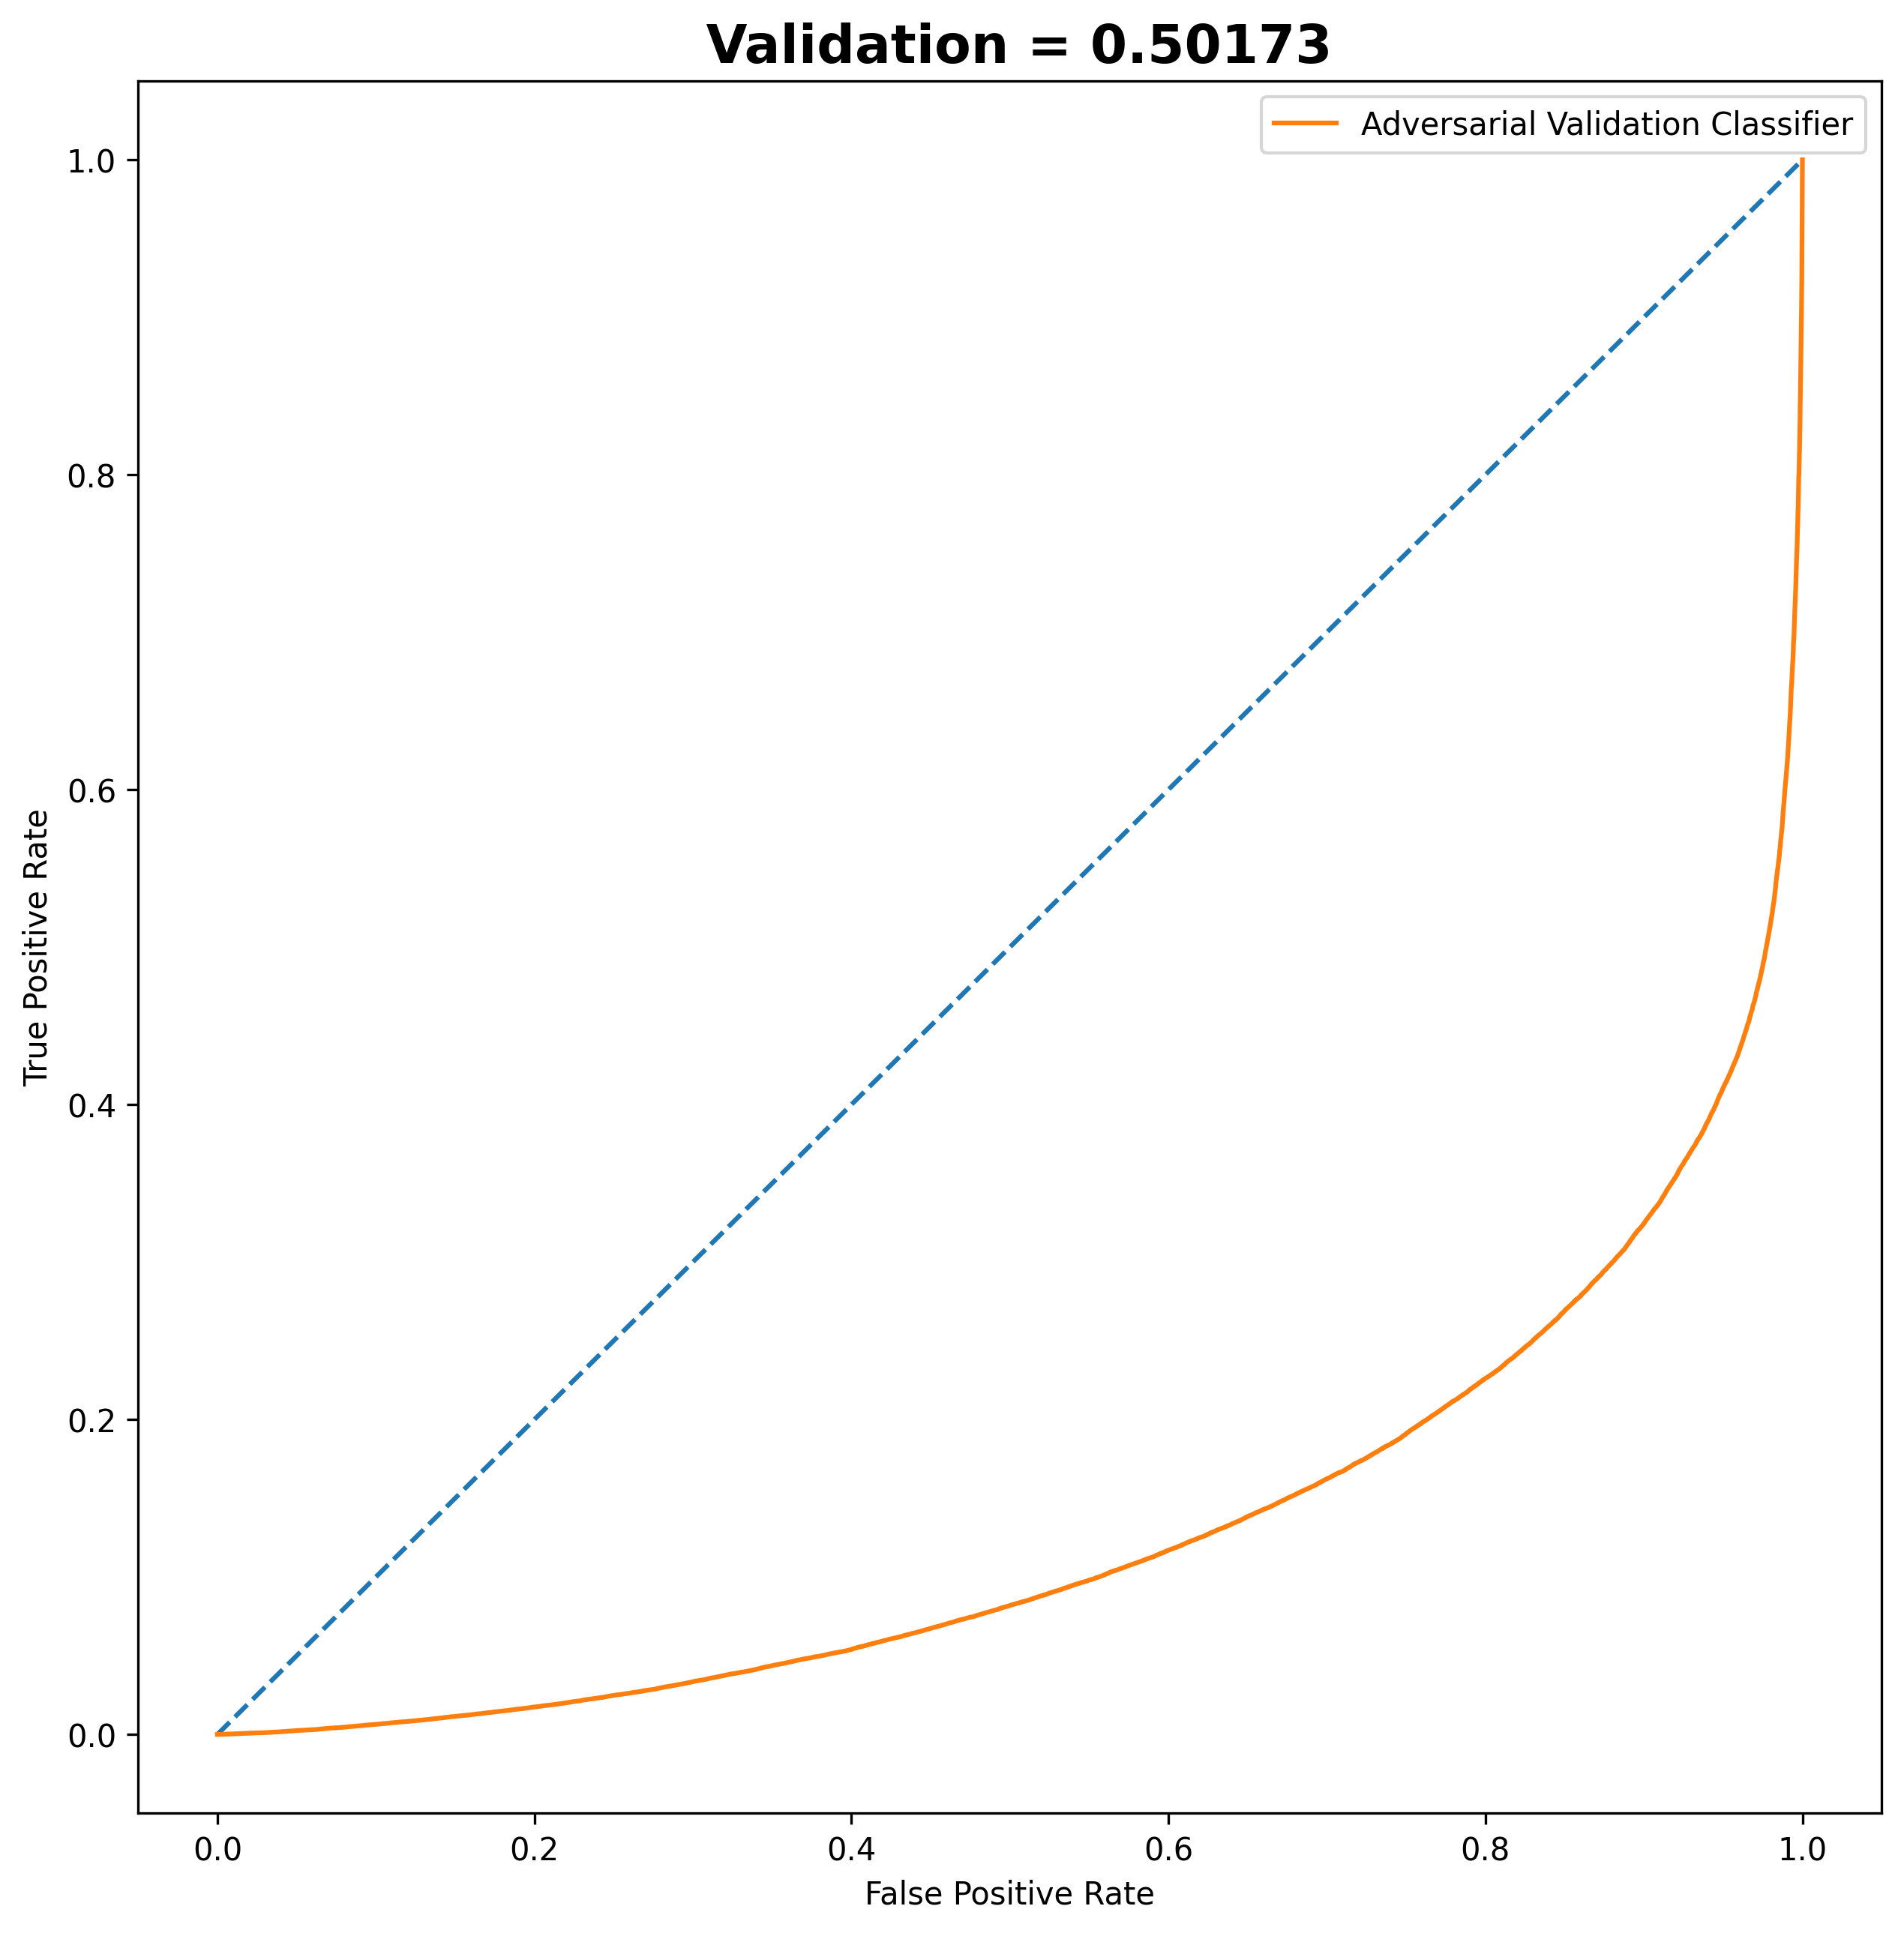

In [91]:
plt.figure(figsize = (10, 10), dpi = 300)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--")
sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
plt.title(f' Validation = {np.mean(score):.5f}', weight = 'bold', size = 17)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Text(0.5, 1.0, 'Feature importances')

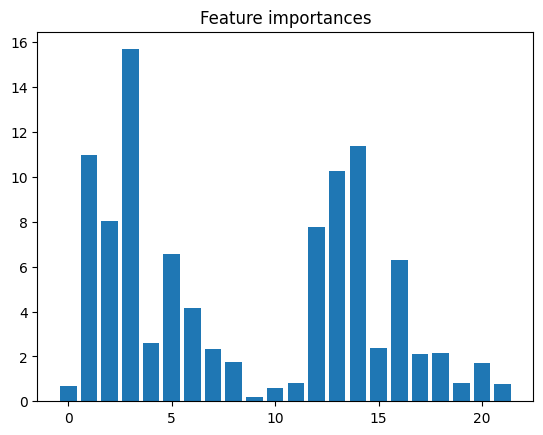

In [61]:
plt.bar(x=range(meta_train_x.shape[1]),height=clf_grid.best_estimator_.feature_importances_)
plt.title('Feature importances')

In [62]:
np.argsort(clf_grid.best_estimator_.feature_importances_)[::-1]

array([ 3, 14,  1, 13,  2, 12,  5, 16,  6,  4, 15,  7, 18, 17,  8, 20, 11,
       19, 21,  0, 10,  9])

In [63]:
top3 = np.argsort(clf_grid.best_estimator_.feature_importances_)[::-1][:3]
indeces_of_important = top3 // 3
print('3 most important models in ensemble')
[list(config.keys())[i] for i in indeces_of_important]

3 most important models in ensemble


['xgb', 'rf', 'logreg']

In [64]:
sample_df['smoking'] = answers[:, 1]
sample_df.to_csv('sample_submission.csv', index=False)

In [65]:
sample_df

,id,smoking
0,159256,0.595844
1,159257,0.213683
2,159258,0.347294
3,159259,0.021204
4,159260,0.580849
...,...,...
106166,265422,0.583648
106167,265423,0.525235
106168,265424,0.503411
106169,265425,0.090290
